# **Step 1: Installing Libraries**

In [1]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.8/882.8 kB 11.7 MB/s eta 0:00:00


# **Step 2: Importing the libraries**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from ultralytics import YOLO, solutions
import cv2
from google.colab.patches import cv2_imshow

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# **Step 3:Importing trained YOLO11x model.**

In [4]:
model = YOLO("/content/drive/MyDrive/YOLOCOUNTER/trained11modelx.pt")

# Step 4: The Processed Videos

In [5]:

vid_path = '/content/drive/MyDrive/YOLOCOUNTER/Freezedvideo.mp4'
video = cv2.VideoCapture(vid_path)

# **Step 4: Extract Video Dimensions and Frame Rate**

In [6]:
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = video.get(cv2.CAP_PROP_FPS)
print(fps)

30.0


# **Step 5: Initialize Video Writer for Output**

In [7]:
output_path = '/content/drive/MyDrive/YOLOCOUNTER/outputSFreezed.mp4'
VIDEO_CODEC = "MP4V"
output_video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*VIDEO_CODEC), fps, (width, height))

# **Step 6: Read Frame for Processing and show the frame.**

In [8]:
_, img = video.read()

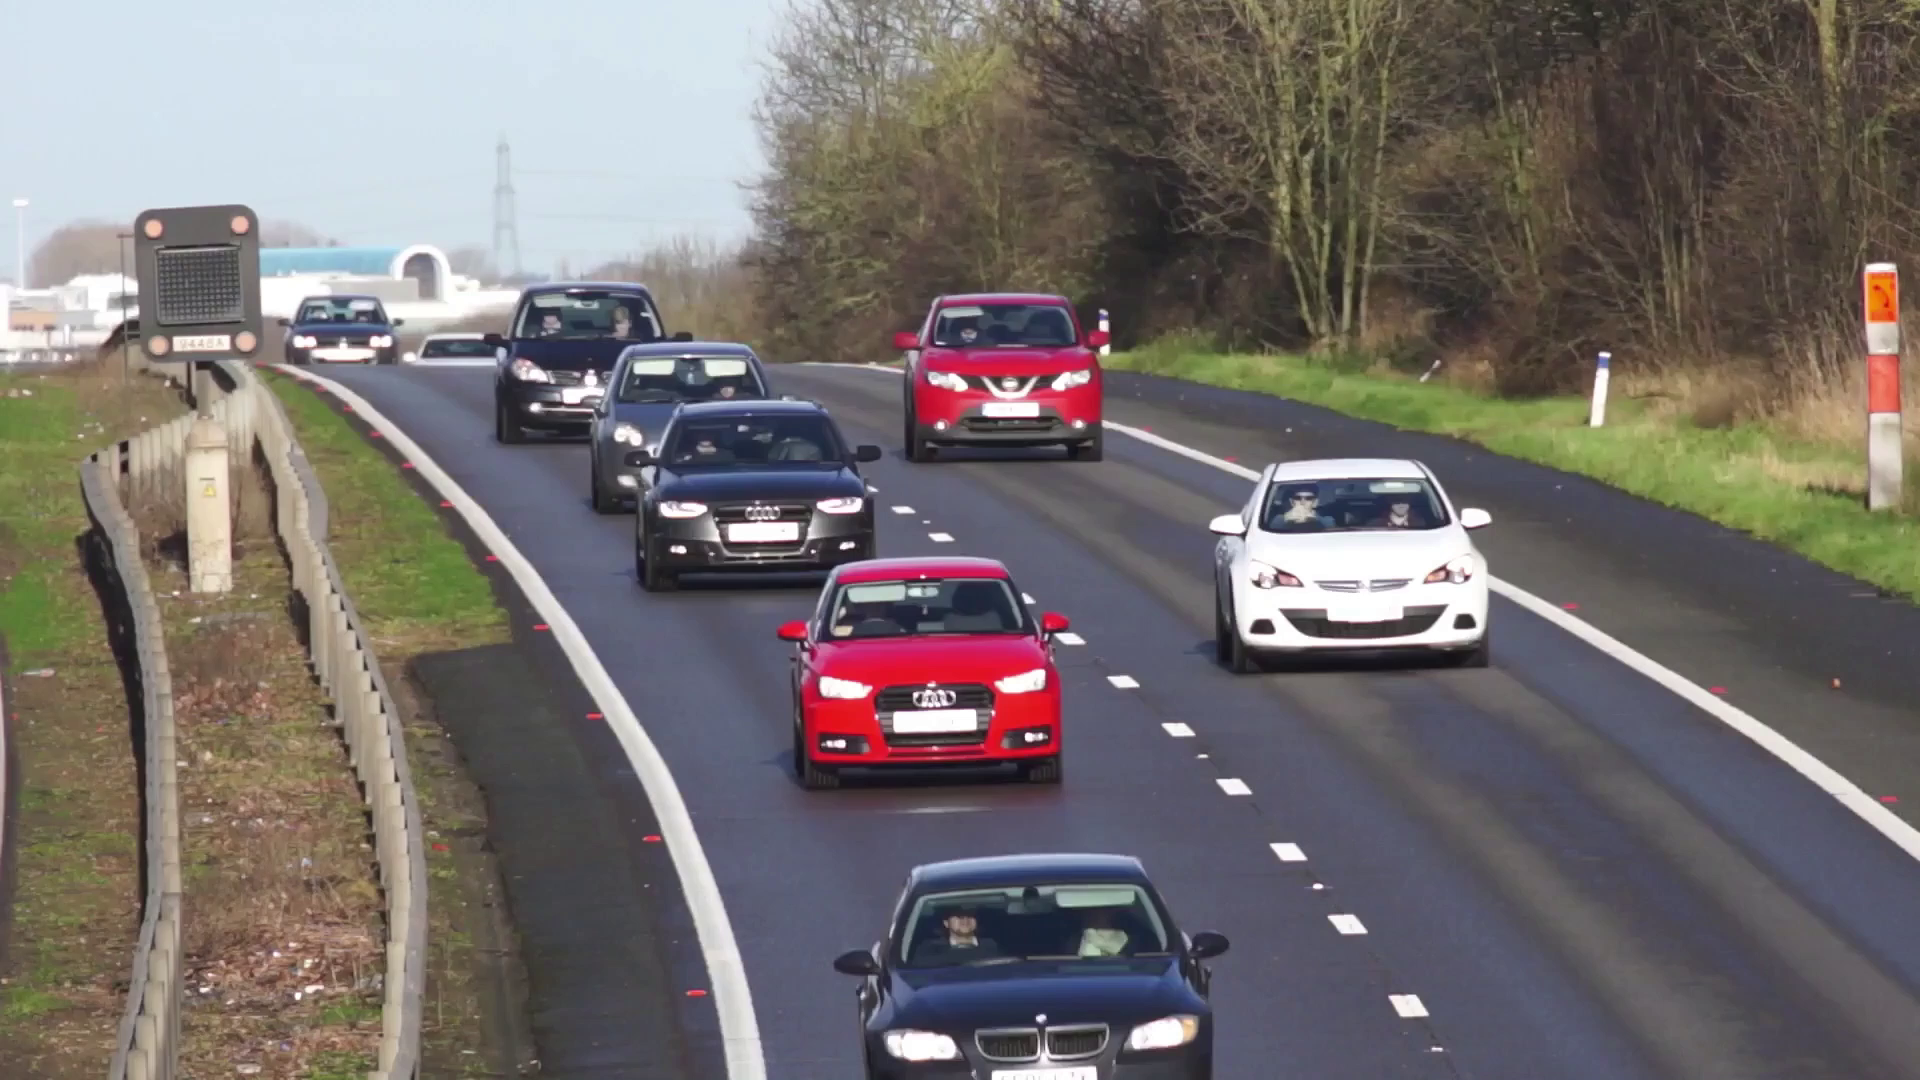

In [9]:
cv2_imshow(img)

# **Step 7: Print Video Dimensions**

In [10]:
print(width)
print(height)

1920
1080


# **Step 8: Specifiying The region of interest.**

In [11]:
rect_width = int(width * 0.8)  # Now 70% of the video width
rect_height = int(height * 0.8)  # Now 70% of the video height
print(rect_width)
print(rect_height)

1536
864


In [12]:
center_x = width // 2
center_y = height // 2
top_left = (center_x - rect_width // 2, center_y - rect_height // 2)
bottom_right = (center_x + rect_width // 2, center_y + rect_height // 2)

# **Step 9: Printing the frame to confirm the ROI.**

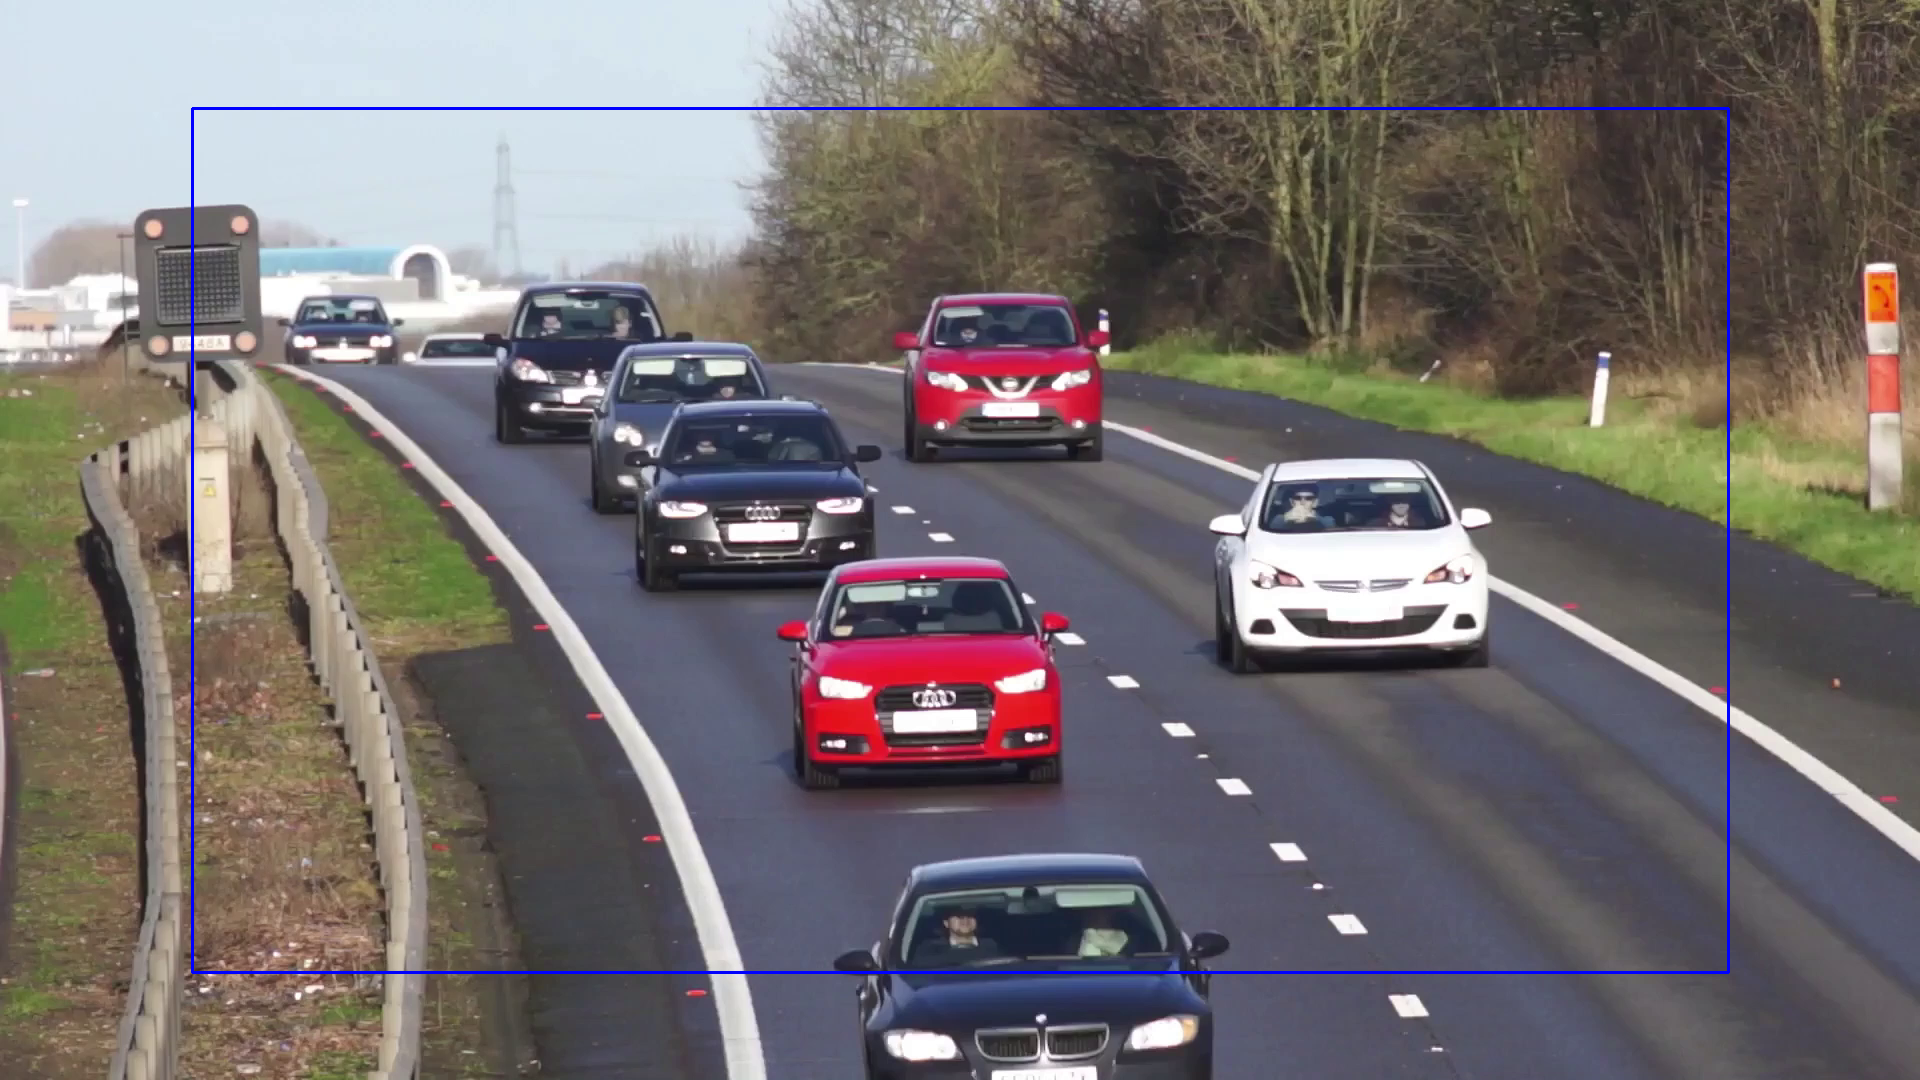

In [14]:

video = cv2.VideoCapture(vid_path)
ret, frame = video.read()


cv2.rectangle(frame, top_left, bottom_right, (255, 0, 0), 2)

cv2_imshow(frame)

# **Step 10: Processing the video.**

In [15]:
# caluclating the averge time for the cars that aren't moving.

import cv2
import time
import numpy as np

# Initialize the video
video = cv2.VideoCapture(vid_path)

# Get the frame rate of the video
fps = video.get(cv2.CAP_PROP_FPS)
frame_duration = 1 / fps  # Each frame corresponds to this much time in seconds

# Initialize dictionaries and variables
exit_counts = {'center': 0}
tracked_ids = {'center': set()}
object_timers = {}        # Dictionary to store cumulative stationary time for each object
positions = {}            # Dictionary to store positions of objects
stationary_frames = {}    # Dictionary to count consecutive frames an object is stationary

# Define thresholds
DISPLACEMENT_THRESHOLD = 2  # Pixels; adjust based on video resolution
STATIONARY_FRAME_COUNT = 5  # Number of consecutive frames to consider an object as stationary

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    # Use device 'cpu' for tracking
    results = model.track(frame, persist=True, verbose=False, device='cpu')

    if (results[0] is not None and results[0].boxes is not None and
        hasattr(results[0].boxes, 'id')):
        boxes = results[0].boxes.xywh.cpu().numpy()
        track_ids = results[0].boxes.id.int().cpu().tolist()
        clss = results[0].boxes.cls.cpu().tolist()
        confs = results[0].boxes.conf.cpu().tolist()

        # Iterate over each detected object (car)
        for i, box in enumerate(boxes):
            x, y, w, h = map(int, box[:4])
            x1, y1 = int(x - w / 2), int(y - h / 2)
            x2, y2 = int(x + w / 2), int(y + h / 2)
            center_x, center_y = x, y
            track_id = track_ids[i]
            conf = confs[i]
            cls = clss[i]

            # Check if the object is inside the central ROI (rectangle)
            if (top_left[1] < center_y < bottom_right[1] and
                top_left[0] < center_x < bottom_right[0]):

                # Update positions dictionary
                if track_id in positions:
                    prev_x, prev_y = positions[track_id]
                    displacement = np.sqrt((center_x - prev_x) ** 2 + (center_y - prev_y) ** 2)

                    if displacement < DISPLACEMENT_THRESHOLD:
                        # Object is considered stationary in this frame
                        stationary_frames[track_id] = stationary_frames.get(track_id, 0) + 1
                    else:
                        # Object is moving
                        stationary_frames[track_id] = 0  # Reset counter

                    # Start timing if the object has been stationary for the required number of frames
                    if stationary_frames[track_id] >= STATIONARY_FRAME_COUNT:
                        if track_id not in object_timers:
                            object_timers[track_id] = 0  # Start timer for this object
                        else:
                            object_timers[track_id] += frame_duration  # Increment timer

                        # Display the time spent stationary for this object
                        cv2.putText(
                            frame,
                            f'Time: {object_timers[track_id]:.2f}s',
                            (x1, y1 - 30),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1.2,
                            (0, 0, 255),
                            2
                        )
                        # Optionally, change the bounding box color for stationary cars
                        box_color = (0, 0, 255)  # Red for stationary
                    else:
                        box_color = (0, 255, 0)  # Green for moving
                else:
                    # First time seeing this object; initialize position and stationary frame count
                    positions[track_id] = (center_x, center_y)
                    stationary_frames[track_id] = 0
                    box_color = (0, 255, 0)  # Green for moving

                # Update the positions with the current position
                positions[track_id] = (center_x, center_y)

                # Draw the bounding box around the detected objects
                cv2.rectangle(frame, (x1, y1), (x2, y2), box_color, 2)
                cv2.putText(
                    frame,
                    f'ID: {track_id} Class: {cls}',
                    (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.2,
                    box_color,
                    2
                )
            else:
                # Object is outside the ROI; reset counters if necessary
                stationary_frames.pop(track_id, None)
                object_timers.pop(track_id, None)
                positions.pop(track_id, None)

                # Draw the bounding box with default color
                cv2.rectangle(frame, (x1, y1), (x2, y2), (200, 200, 200), 2)
                cv2.putText(
                    frame,
                    f'ID: {track_id} Class: {cls}',
                    (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.2,
                    (200, 200, 200),
                    2
                )

    # Draw the large rectangle in the middle of the frame
    cv2.rectangle(frame, top_left, bottom_right, (255, 0, 0), 2)

    # Calculate the average waiting time so far
    total_time_so_far = sum(object_timers.values())
    total_objects_so_far = len(object_timers)
    if total_objects_so_far > 0:
        average_waiting_time_so_far = total_time_so_far / total_objects_so_far
    else:
        average_waiting_time_so_far = 0

    # Display the average waiting time on the frame
    cv2.putText(
        frame,
        f'Avg Time: {average_waiting_time_so_far:.2f}s',
        (50, 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.2,
        (0, 0, 255),
        2
    )

    output_video.write(frame)

# After the video has finished, print the total time and number of objects
total_time = sum(object_timers.values())
total_objects = len(object_timers)

if total_objects > 0:
    average_waiting_time = total_time / total_objects
else:
    average_waiting_time = 0

print(f"Total time spent by stationary objects inside the rectangle: {total_time:.2f} seconds")
print(f"Total number of stationary objects: {total_objects}")
print(f"Average waiting time: {average_waiting_time:.2f} seconds")

video.release()
output_video.release()
cv2.destroyAllWindows()


requirements: Ultralytics requirement ['lapx>=0.5.2'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 5.0s, installed 1 package: ['lapx>=0.5.2']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

Total time spent by stationary objects inside the rectangle: 0.03 seconds
Total number of stationary objects: 1
Average waiting time: 0.03 seconds
